In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostRegressor

from tqdm.notebook import tqdm

from tqdm import tqdm
from bs4 import BeautifulSoup  as bs
from pprint import pprint  
import requests  
import json
from ast import literal_eval
import json

import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

import my_func
import importlib
importlib.reload(my_func)

<module 'my_func' from 'c:\\Users\\Evgen\\skillfactory\\Projects\\Project_5\\my_func.py'>

In [2]:
train = pd.read_csv('data_versions/parsed_data_1.csv')
train.dropna(subset=['price'], inplace=True)
# Почистим от дубликатов
pd.set_option('float_format', '{:f}'.format)
# print(data.sell_id.value_counts())
print('Размер до очистки от дублей', train.shape)
train.drop_duplicates(subset ="sell_id", keep = False, inplace = True)
print('Размер после очистки от дублей', train.shape)

test = pd.read_csv('kaggle/test.csv')
# test.dropna(subset=['price'], inplace=True)

sample_submission = pd.read_csv('kaggle/sample_submission.csv')

Размер до очистки от дублей (88297, 29)
Размер после очистки от дублей (86429, 29)


In [3]:
df_train = train
df_test = test
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.columns = ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'owners', 'owning', 'pts', 'privod', 'wheel', 
       'state', 'customs', 'sample', 'Unnamed: 0','seller_name', 'price']

In [4]:
data['enginePower'] = data['enginePower'].apply(lambda x: int(x.replace(' N12', '')) if type(x)==str else x)

In [5]:
print('граница выбросов километража: ' ,my_func.outlier_treatment(data.mileage))

# Оставим значения свыше границы, но в пределах 600к
# data = data[(data.mileage<600_000)&(data['sample']==1)]
data['mileage'] = data['mileage'].apply(lambda x: 600_000 if x>600_000 else x)

граница выбросов километража:  (-154328.75, 399797.25)


<AxesSubplot:>

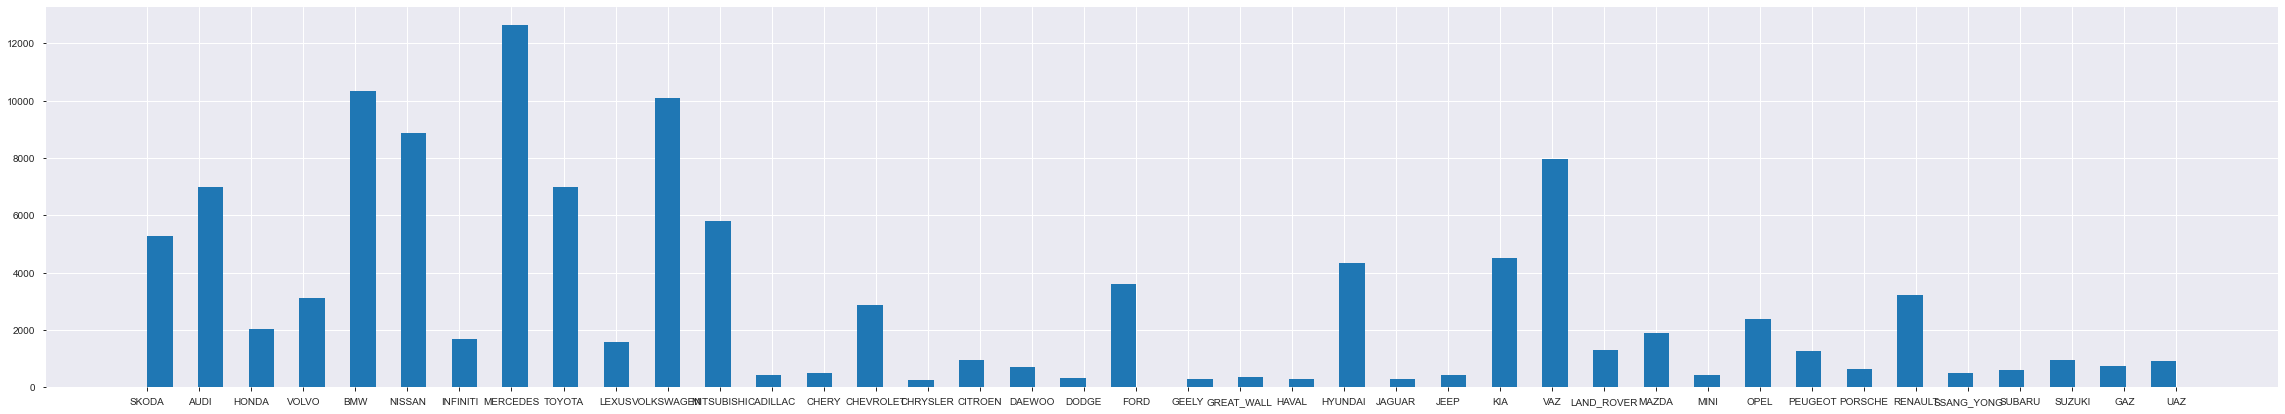

In [6]:
top40branbs = data.brand.value_counts().head(40).keys()
fig, ax = plt.subplots(figsize = (40, 7))
data[data.brand.isin(top40branbs)].brand.hist(bins = 80)

In [7]:
cat_cols = data.select_dtypes(np.object).columns.to_list()
cat_cols = ['bodyType',
 'brand',
 'engineDisplacement',
 'fuelType',
 'model_name',
 'vehicleTransmission',
 'owning',
 'pts',
 'privod',
 'wheel',
 'state',
 'customs']

In [8]:
# for catcol in cat_cols:
#     top40 = data[catcol].value_counts().head(10).keys()
#     my_func.hist_cat_num(data[data[catcol].isin(top40)], catcol, 'mileage', f'{catcol} on price')

<AxesSubplot:>

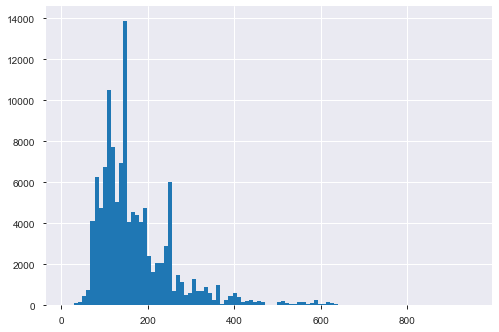

In [9]:
data.enginePower.hist(bins=100)
# data[data.mileage==0].shape

In [10]:
# my_func.hist_cat_num(data, 'modelDate', 'mileage', 'modelDate on mileage')
# data.groupby(by='modelDate').mileage.mean().tail(50)

In [16]:
data.groupby(by='productionDate').price.mean().head(50)

data[data.productionDate==1904]

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,owning,pts,privod,wheel,state,customs,sample,Unnamed: 0,seller_name,price
16944,кабриолет,MERCEDES,https://auto.ru/cars/used/sale/mercedes/simple...,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3 LTR,32.000000,NaN,бензин,...,6 лет и 8 месяцев,Оригинал,задний,Правый,Не требует ремонта,Растаможен,0,nan,NaN,nan


In [18]:
data.groupby(by='bodyType').price.mean().head(50)

bodyType
внедорожник 3 дв.          634759.092116
внедорожник 5 дв.         2421433.283631
внедорожник открытый       404249.990385
кабриолет                 3198587.838509
компактвэн                 445041.143746
купе                      3362571.260442
купе-хардтоп              1270711.635220
лимузин                   8165214.500000
лифтбек                    981238.046497
микровэн                   418419.322581
минивэн                   1897077.728489
пикап двойная кабина      1680682.768924
пикап одинарная кабина    1387545.454545
пикап полуторная кабина   1512187.437500
родстер                   3227370.148936
седан                     1061254.085902
седан 2 дв.                252355.048193
седан-хардтоп              147272.727273
спидстер                  7701982.250000
тарга                     5303573.666667
универсал 5 дв.            562847.707468
фастбек                    598000.000000
фургон                     509216.737557
хэтчбек 3 дв.              489579.727323
хэтчбек